In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.pgn
import chess.engine
import io
import json
from tqdm import tqdm
import os





In [3]:
# Đọc file CSV
df = pd.read_csv('ai/data/games_wgm.csv')

# Hiển thị 5 dòng đầu tiên để kiểm tra
print(len(df))
print(df.columns)
print(df.head())

304767
Index(['game_id', 'game_url', 'pgn', 'time_control', 'end_time', 'rated',
       'time_class', 'rules', 'wgm_username', 'white_username', 'white_rating',
       'white_result', 'black_username', 'black_rating', 'black_result'],
      dtype='object')
     game_id                                   game_url  \
0  372626070  https://www.chess.com/live/game/372626070   
1  376650570  https://www.chess.com/live/game/376650570   
2  593979727  https://www.chess.com/live/game/593979727   
3  613859708  https://www.chess.com/live/game/613859708   
4  634471928  https://www.chess.com/live/game/634471928   

                                                 pgn time_control  \
0  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      4500+30   
1  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      3600+30   
2  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      4500+30   
3  [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...      3600+30   
4  [Event "Live Chess"]\n[Site "Chess.com"]

In [4]:
df[['pgn']]

,pgn
0,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
1,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
2,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
3,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
4,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
...,...
304762,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
304763,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
304764,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
304765,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."



Thông tin bảng dữ liệu sau xử lý và lọc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304767 entries, 0 to 304766
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   game_id         304767 non-null  object
 1   game_url        304767 non-null  object
 2   pgn             301294 non-null  object
 3   time_control    304767 non-null  object
 4   end_time        304767 non-null  object
 5   rated           304767 non-null  bool  
 6   time_class      304767 non-null  object
 7   rules           304767 non-null  object
 8   wgm_username    304767 non-null  object
 9   white_username  304767 non-null  object
 10  white_rating    304767 non-null  int64 
 11  white_result    304767 non-null  object
 12  black_username  304767 non-null  object
 13  black_rating    304767 non-null  int64 
 14  black_result    304767 non-null  object
 15  EloDifference   304767 non-null  int64 
dtypes: bool(1), int64(3), object(12)

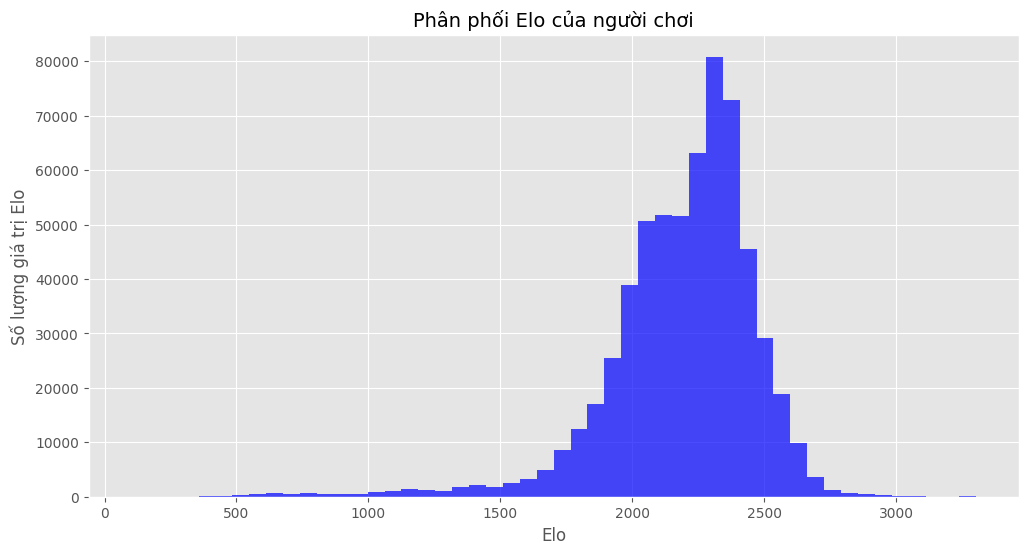

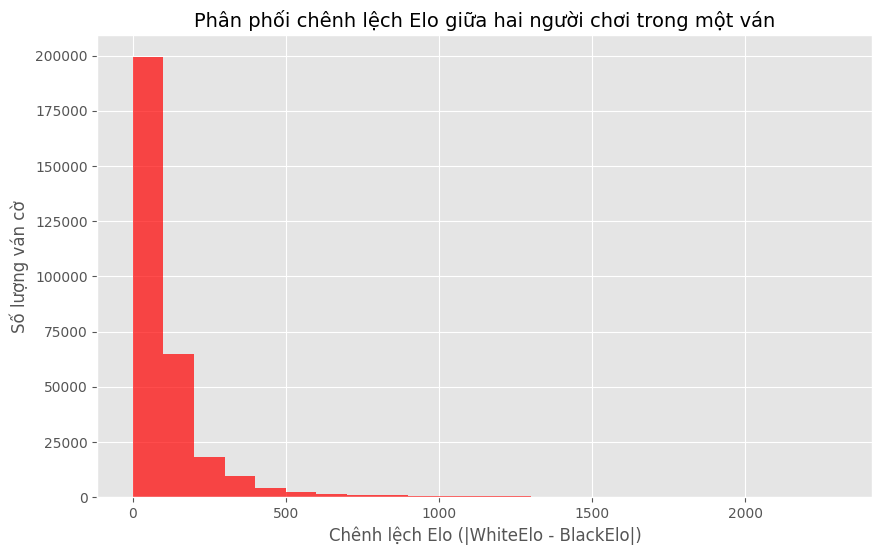

KeyError: 'MoveCount'

<Figure size 1000x600 with 0 Axes>

In [ ]:

df_pgn = df.copy()
# Chuyển đổi Elo thành số
df_pgn['white_rating'] = pd.to_numeric(df_pgn['white_rating'], errors='coerce')
df_pgn['black_rating'] = pd.to_numeric(df_pgn['black_rating'], errors='coerce')

# Loại bỏ các dòng có giá trị NaN trong white_rating hoặc black_rating
df_pgn = df_pgn.dropna(subset=['white_rating', 'black_rating'])

# Chuyển đổi Elo thành số nguyên
df_pgn['white_rating'] = df_pgn['white_rating'].astype(int)
df_pgn['black_rating'] = df_pgn['black_rating'].astype(int)

# Lọc các ván cờ có Elo > 2000
df_pgn_filtered = df_pgn
# Tính chênh lệch Elo tuyệt đối
df_pgn_filtered['EloDifference'] = abs(df_pgn_filtered['white_rating'] - df_pgn_filtered['black_rating'])

# Kết hợp tất cả Elo (white_rating và black_rating)
all_elo = pd.concat([df_pgn_filtered['white_rating'], df_pgn_filtered['black_rating']]).reset_index(drop=True)

# Kiểm tra dữ liệu sau xử lý
print("\nThông tin bảng dữ liệu sau xử lý và lọc:")
print(df_pgn_filtered.info())
print("\n5 hàng đầu tiên của bảng sau xử lý:")
print(df_pgn_filtered.head())

# Thiết lập kiểu hiển thị cho biểu đồ
plt.style.use('ggplot')

# 1. Histogram cho tất cả Elo (white_rating và black_rating kết hợp)
plt.figure(figsize=(12, 6))
max_diff = all_elo.max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.hist(all_elo, bins=50, color='blue', alpha=0.7)
plt.title('Phân phối Elo của người chơi', fontsize=14)
plt.xlabel('Elo', fontsize=12)
plt.ylabel('Số lượng giá trị Elo', fontsize=12)
plt.grid(True)
plt.show()

# 2. Histogram cho chênh lệch Elo (bin width = 100)
max_diff = df_pgn_filtered['EloDifference'].max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['EloDifference'], bins=bins, color='red', alpha=0.7)
plt.title('Phân phối chênh lệch Elo giữa hai người chơi trong một ván', fontsize=14)
plt.xlabel('Chênh lệch Elo (|WhiteElo - BlackElo|)', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# Thống kê cơ bản
print("\nThống kê cơ bản (sau khi lọc Elo > 2000):")
print("Trung bình tất cả Elo:", round(all_elo.mean(), 2))
print("Trung bình chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].mean(), 2))
print("Độ lệch chuẩn tất cả Elo:", round(all_elo.std(), 2))
print("Độ lệch chuẩn chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].std(), 2))


Thông tin bảng dữ liệu sau xử lý và lọc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301294 entries, 0 to 301293
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Result         301294 non-null  object
 1   white_rating   301294 non-null  int64 
 2   black_rating   301294 non-null  int64 
 3   Moves          301294 non-null  object
 4   MoveCount      301294 non-null  int64 
 5   EloDifference  301294 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.8+ MB
None

5 hàng đầu tiên của bảng sau xử lý:
    Result  white_rating  black_rating  \
0      1-0          2577          2262   
1      1-0          2345          2262   
2      1-0          2429          2246   
3  1/2-1/2          2429          2225   
4      1-0          2592          2429   

                                               Moves  MoveCount  EloDifference  
0  e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...         65      

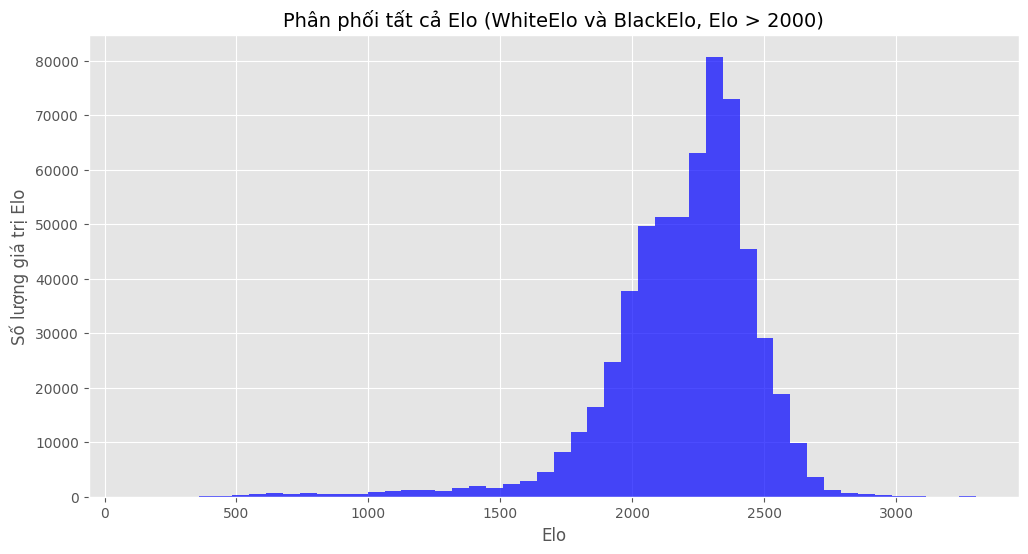

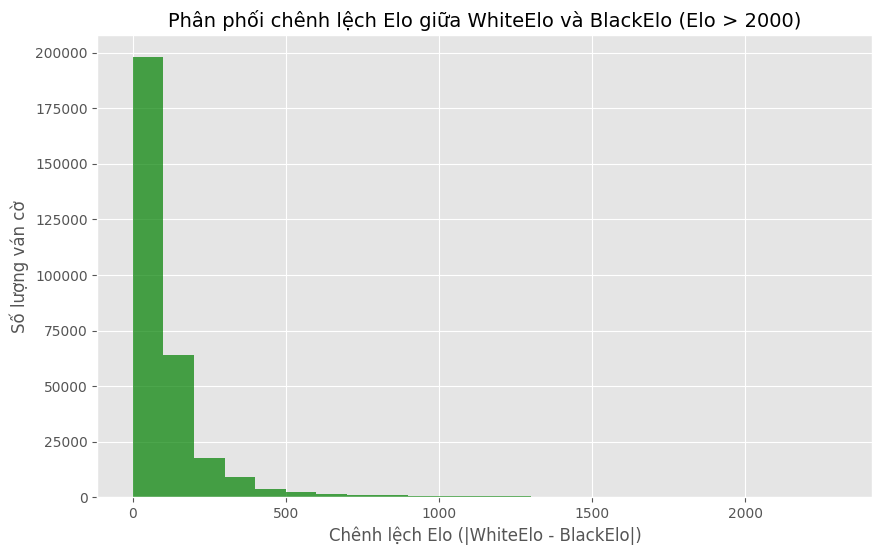

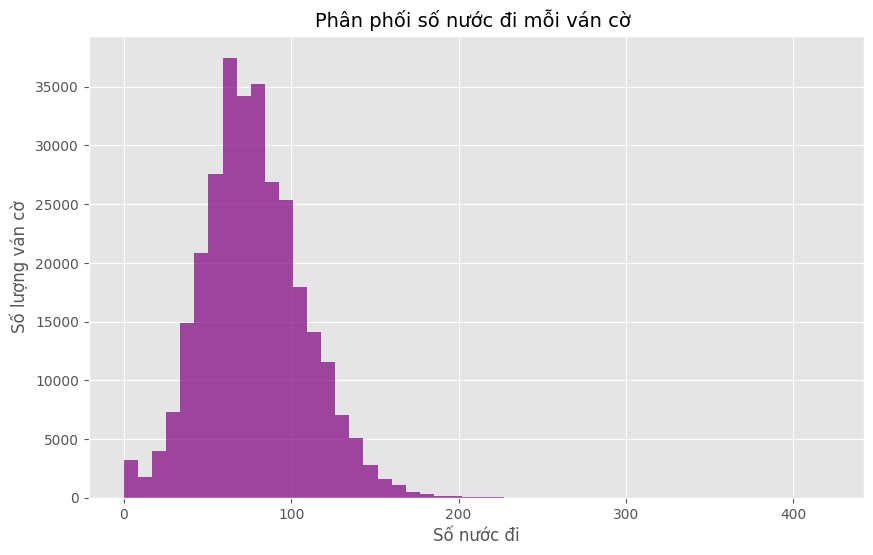


Thống kê cơ bản (sau khi lọc Elo > 2000):
Trung bình tất cả Elo: 2193.75
Trung bình chênh lệch Elo: 112.76
Trung bình số nước đi: 77.84
Độ lệch chuẩn tất cả Elo: 280.01
Độ lệch chuẩn chênh lệch Elo: 172.0
Độ lệch chuẩn số nước đi: 30.31


In [38]:
import re

# Hàm parse PGN để trích xuất thông tin và nước đi
def parse_pgn(pgn_str):
    info = {}
    if not isinstance(pgn_str, str):
        return {
            "Result": None,
            "WhiteElo": None,
            "BlackElo": None,
            "Moves": None
        }
    
    fields = ['Result', 'WhiteElo', 'BlackElo']
    for field in fields:
        match = re.search(rf'\[{field} \"(.*?)\"\]', pgn_str)
        info[field] = match.group(1) if match else None
    
    # Trích xuất nước đi
    game = chess.pgn.read_game(io.StringIO(pgn_str))
    if game is None:
        info['Moves'] = None
    else:
        moves = ""
        for move in game.mainline_moves():
            moves += str(move) + " "
        info['Moves'] = moves.strip()
    
    return info

# Làm sạch dữ liệu: chỉ giữ các dòng có PGN hợp lệ
df_valid = df[df['pgn'].apply(lambda x: isinstance(x, str))].copy()

# Trích xuất thông tin từ PGN
df_pgn = df_valid['pgn'].apply(parse_pgn)
df_pgn = pd.DataFrame(df_pgn.tolist())

# Đổi tên cột để đồng bộ (nếu dữ liệu có white_rating/black_rating, bỏ qua bước này)
df_pgn = df_pgn.rename(columns={'WhiteElo': 'white_rating', 'BlackElo': 'black_rating'})

# Tính MoveCount từ chuỗi Moves
df_pgn['MoveCount'] = df_pgn['Moves'].fillna('').apply(lambda x: len(x.strip().split()))

# Chuyển đổi Elo thành số
df_pgn['white_rating'] = pd.to_numeric(df_pgn['white_rating'], errors='coerce')
df_pgn['black_rating'] = pd.to_numeric(df_pgn['black_rating'], errors='coerce')

# Loại bỏ các dòng có giá trị NaN trong white_rating hoặc black_rating
df_pgn = df_pgn.dropna(subset=['white_rating', 'black_rating'])

# Chuyển đổi Elo thành số nguyên
df_pgn['white_rating'] = df_pgn['white_rating'].astype(int)
df_pgn['black_rating'] = df_pgn['black_rating'].astype(int)

# Lọc các ván cờ có Elo > 2000
df_pgn_filtered = df_pgn

# Tính chênh lệch Elo tuyệt đối
df_pgn_filtered['EloDifference'] = abs(df_pgn_filtered['white_rating'] - df_pgn_filtered['black_rating'])

# Kết hợp tất cả Elo (white_rating và black_rating)
all_elo = pd.concat([df_pgn_filtered['white_rating'], df_pgn_filtered['black_rating']]).reset_index(drop=True)

# Kiểm tra dữ liệu sau xử lý
print("\nThông tin bảng dữ liệu sau xử lý và lọc:")
print(df_pgn_filtered.info())
print("\n5 hàng đầu tiên của bảng sau xử lý:")
print(df_pgn_filtered.head())

# Thiết lập kiểu hiển thị cho biểu đồ
plt.style.use('ggplot')

# 1. Histogram cho tất cả Elo (white_rating và black_rating kết hợp)
plt.figure(figsize=(12, 6))
plt.hist(all_elo, bins=50, color='blue', alpha=0.7)
plt.title('Phân phối tất cả Elo (WhiteElo và BlackElo, Elo > 2000)', fontsize=14)
plt.xlabel('Elo', fontsize=12)
plt.ylabel('Số lượng giá trị Elo', fontsize=12)
plt.grid(True)
plt.show()

# 2. Histogram cho chênh lệch Elo (bin width = 100)
max_diff = df_pgn_filtered['EloDifference'].max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['EloDifference'], bins=bins, color='green', alpha=0.7)
plt.title('Phân phối chênh lệch Elo giữa WhiteElo và BlackElo (Elo > 2000)', fontsize=14)
plt.xlabel('Chênh lệch Elo (|WhiteElo - BlackElo|)', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# 3. Histogram cho số nước đi (MoveCount)
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['MoveCount'], bins=50, color='purple', alpha=0.7)
plt.title('Phân phối số nước đi mỗi ván cờ ', fontsize=14)
plt.xlabel('Số nước đi', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# Thống kê cơ bản
print("\nThống kê cơ bản (sau khi lọc Elo > 2000):")
print("Trung bình tất cả Elo:", round(all_elo.mean(), 2))
print("Trung bình chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].mean(), 2))
print("Trung bình số nước đi:", round(df_pgn_filtered['MoveCount'].mean(), 2))
print("Độ lệch chuẩn tất cả Elo:", round(all_elo.std(), 2))
print("Độ lệch chuẩn chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].std(), 2))
print("Độ lệch chuẩn số nước đi:", round(df_pgn_filtered['MoveCount'].std(), 2))

In [5]:
import re
df_png = df[['pgn']].copy()
df_png = df_png[df_png['pgn'].apply(lambda x: isinstance(x, str))]

# Hàm để parse PGN và lấy thông tin cần thiết: Kết quả, Elo của người chơi trắng và đen, vị trí hiện tại, các nước đi
def parse_pgn(pgn_str):
    info = {}

    # Nếu không phải string thì trả về NaN cho toàn bộ
    if not isinstance(pgn_str, str):
        return {
            "Result": None,
            "WhiteElo": None,
            "BlackElo": None,
            "CurrentPosition": None,
            "Moves": None
        }

    fields = ['Result', 'WhiteElo', 'BlackElo', 'CurrentPosition']
    
    # Tìm các thông tin trong PGN
    for field in fields:
        match = re.search(rf'\[{field} "(.*?)"\]', pgn_str)
        info[field] = match.group(1) if match else None

    return info

# Hàm phân tích các nước đi từ cột PGN
def parse_moves(pgn):
    if not isinstance(pgn, str):
        return None

    moves = ""
    game = chess.pgn.read_game(io.StringIO(pgn))

    if game is None:
        return None

    for move in game.mainline_moves():
        moves += str(move) + " "
    return moves.strip()



In [6]:
# Không chạy cell này vì nó có tác dụng làm clean data thành file pgn_chess_data.csv và chạy lâu
# Bỏ các dòng không có PGN hợp lệ
df_valid = df[df['pgn'].apply(lambda x: isinstance(x, str))].copy()

# Phân tích header
df_pgn = df_valid['pgn'].apply(parse_pgn)
df_pgn = pd.DataFrame(df_pgn.tolist())

# Phân tích nước đi
df_pgn["Moves"] = df_valid['pgn'].apply(parse_moves)

In [7]:
table = df_pgn.copy()
print(table.columns)
print(table.shape)
print(table.describe())
print(table.info())
print(table.head(10))


Index(['Result', 'WhiteElo', 'BlackElo', 'CurrentPosition', 'Moves'], dtype='object')
(301294, 5)
        Result WhiteElo BlackElo  \
count   301294   301294   301294   
unique       3     2568     2574   
top        1-0     2317     2316   
freq    149085      762      753   

                                          CurrentPosition   Moves  
count                                              301294  297821  
unique                                             296420  294216  
top     rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...          
freq                                                  863    1070  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301294 entries, 0 to 301293
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Result           301294 non-null  object
 1   WhiteElo         301294 non-null  object
 2   BlackElo         301294 non-null  object
 3   CurrentPosition  301294 non-null  ob

In [8]:

# Hàm thống kê cơ bản cho các cột
def summarize_column(df, column):
    unique_values = df[column].nunique()
    total_values = len(df[column])
    non_null_values = df[column].notna().sum()
    null_values = df[column].isna().sum()
    return {
        'Cột': column,
        'Giá trị duy nhất': unique_values,
        'Tổng số giá trị': total_values,
        'Không null': non_null_values,
        'Null/NaN': null_values
    }

# Áp dụng cho tất cả các cột
summary = pd.DataFrame([summarize_column(table, col) for col in table.columns])

# Xử lý riêng cho cột Moves: đếm số bước đi trong mỗi ván
table['MoveCount'] = table['Moves'].fillna('').apply(lambda x: len(x.strip().split()))

# Thống kê số bước đi
move_stats = {
    'Tổng số ván': table.shape[0],
    'Tổng số bước đi': table['MoveCount'].sum(),
    'Trung bình số bước mỗi ván': table['MoveCount'].mean(),
    'Số bước ít nhất': table['MoveCount'].min(),
    'Số bước nhiều nhất': table['MoveCount'].max()
}

# In kết quả
print("Thống kê tổng quát các cột:")
print(summary.to_string(index=False))
print("\nThống kê số bước đi từ cột Moves:")
for k, v in move_stats.items():
    print(f"{k}: {v}")

Thống kê tổng quát các cột:
            Cột  Giá trị duy nhất  Tổng số giá trị  Không null  Null/NaN
         Result                 3           301294      301294         0
       WhiteElo              2568           301294      301294         0
       BlackElo              2574           301294      301294         0
CurrentPosition            296420           301294      301294         0
          Moves            294216           301294      297821      3473

Thống kê số bước đi từ cột Moves:
Tổng số ván: 301294
Tổng số bước đi: 23169915
Trung bình số bước mỗi ván: 76.90134884863289
Số bước ít nhất: 0
Số bước nhiều nhất: 421


In [9]:
table

,Result,WhiteElo,BlackElo,CurrentPosition,Moves,MoveCount
0,1-0,2577,2262,r7/pp1k1R1p/1b2p3/4Q1B1/1P1p2N1/7q/P7/6K1 b - -,e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...,65
1,1-0,2345,2262,4k3/7p/2PR2p1/3P1p2/5P2/4K1P1/2r4P/8 b - -,d2d4 g8f6 g1f3 g7g6 c2c4 f8g7 g2g3 e8g8 f1g2 d...,95
2,1-0,2429,2246,8/8/4p1p1/Q3P1B1/5Pk1/KP1q4/8/8 b - -,e2e4 c7c5 g1f3 e7e6 d2d4 c5d4 f3d4 b8c6 b1c3 d...,87
3,1/2-1/2,2429,2225,5k2/1r2pp1p/2N1n1p1/1p1R4/p7/P1P2P2/1P3BPP/2b1...,e2e4 g8f6 e4e5 f6d5 d2d4 d7d6 g1f3 g7g6 f1c4 c...,80
4,1-0,2592,2429,1b1Q1q1k/1p5p/p2N4/P4p2/4p3/4P2P/1P4P1/3R3K b - -,d2d4 g8f6 c2c4 e7e6 g1f3 c7c5 d4d5 d7d6 b1c3 e...,81
...,...,...,...,...,...,...
301289,0-1,2534,2423,r5k1/5pp1/3Q3p/1N2p3/K1P5/P1R5/8/1q6 w - -,e2e4 e7e5 g1f3 d7d6 d2d4 g8f6 b1c3 b8d7 f1c4 f...,60
301290,0-1,2526,2524,7r/p2R2p1/4pbkp/2B5/2K3PP/8/2r5/5R2 w - -,e2e4 c7c5 f1e2 d7d6 f2f4 g7g6 g1f3 f8g7 e1g1 b...,128
301291,0-1,2516,2534,5rk1/1p3pp1/4pnp1/pPq5/4P3/PQ3BPP/5PK1/8 w - -,e2e4 c7c5 g1f3 d7d6 d2d4 c5d4 f3d4 g8f6 b1c3 a...,60
301292,0-1,2526,2524,6k1/5p2/p1q1p1p1/1p5p/7R/P1P5/1P1r1rPP/2Q3RK w...,e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 e1g1 f...,120


In [10]:
table["MoveCount"] = pd.to_numeric(table["MoveCount"], errors="coerce")
table["MoveCount"] = table["MoveCount"].fillna(0)
table = table[table["MoveCount"] > 40]

table


,Result,WhiteElo,BlackElo,CurrentPosition,Moves,MoveCount
0,1-0,2577,2262,r7/pp1k1R1p/1b2p3/4Q1B1/1P1p2N1/7q/P7/6K1 b - -,e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...,65
1,1-0,2345,2262,4k3/7p/2PR2p1/3P1p2/5P2/4K1P1/2r4P/8 b - -,d2d4 g8f6 g1f3 g7g6 c2c4 f8g7 g2g3 e8g8 f1g2 d...,95
2,1-0,2429,2246,8/8/4p1p1/Q3P1B1/5Pk1/KP1q4/8/8 b - -,e2e4 c7c5 g1f3 e7e6 d2d4 c5d4 f3d4 b8c6 b1c3 d...,87
3,1/2-1/2,2429,2225,5k2/1r2pp1p/2N1n1p1/1p1R4/p7/P1P2P2/1P3BPP/2b1...,e2e4 g8f6 e4e5 f6d5 d2d4 d7d6 g1f3 g7g6 f1c4 c...,80
4,1-0,2592,2429,1b1Q1q1k/1p5p/p2N4/P4p2/4p3/4P2P/1P4P1/3R3K b - -,d2d4 g8f6 c2c4 e7e6 g1f3 c7c5 d4d5 d7d6 b1c3 e...,81
...,...,...,...,...,...,...
301289,0-1,2534,2423,r5k1/5pp1/3Q3p/1N2p3/K1P5/P1R5/8/1q6 w - -,e2e4 e7e5 g1f3 d7d6 d2d4 g8f6 b1c3 b8d7 f1c4 f...,60
301290,0-1,2526,2524,7r/p2R2p1/4pbkp/2B5/2K3PP/8/2r5/5R2 w - -,e2e4 c7c5 f1e2 d7d6 f2f4 g7g6 g1f3 f8g7 e1g1 b...,128
301291,0-1,2516,2534,5rk1/1p3pp1/4pnp1/pPq5/4P3/PQ3BPP/5PK1/8 w - -,e2e4 c7c5 g1f3 d7d6 d2d4 c5d4 f3d4 g8f6 b1c3 a...,60
301292,0-1,2526,2524,6k1/5p2/p1q1p1p1/1p5p/7R/P1P5/1P1r1rPP/2Q3RK w...,e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 e1g1 f...,120


In [11]:
summary = pd.DataFrame([summarize_column(table, col) for col in table.columns])
move_stats = {
    'Tổng số ván': table.shape[0],
    'Tổng số bước đi': table['MoveCount'].sum(),
    'Trung bình số bước mỗi ván': table['MoveCount'].mean(),
    'Số bước ít nhất': table['MoveCount'].min(),
    'Số bước nhiều nhất': table['MoveCount'].max()
}

# In kết quả
print("Thống kê tổng quát các cột:")
print(summary.to_string(index=False))
print("\nThống kê số bước đi từ cột Moves:")
for k, v in move_stats.items():
    print(f"{k}: {v}")

Thống kê tổng quát các cột:
            Cột  Giá trị duy nhất  Tổng số giá trị  Không null  Null/NaN
         Result                 3           271149      271149         0
       WhiteElo              2483           271149      271149         0
       BlackElo              2492           271149      271149         0
CurrentPosition            267210           271149      271149         0
          Moves            270048           271149      271149         0
      MoveCount               231           271149      271149         0

Thống kê số bước đi từ cột Moves:
Tổng số ván: 271149
Tổng số bước đi: 22445350
Trung bình số bước mỗi ván: 82.77865675329801
Số bước ít nhất: 41
Số bước nhiều nhất: 421


In [12]:

# Chuyển đổi Elo thành số
table["WhiteElo"] = pd.to_numeric(table["WhiteElo"], errors="coerce")
table["BlackElo"] = pd.to_numeric(table["BlackElo"], errors="coerce")
# Loại bỏ các dòng có giá trị NaN trong cột Elo
table = table.dropna(subset=["WhiteElo", "BlackElo"])
# Chuyển đổi Elo thành số nguyên
table["WhiteElo"] = table["WhiteElo"].astype(int)
table["BlackElo"] = table["BlackElo"].astype(int)
table = table[table["WhiteElo"] > 2000]
table = table[table["BlackElo"] > 2000]
table



C:\Users\Admin\AppData\Local\Temp\ipykernel_1528\1511119488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["WhiteElo"] = pd.to_numeric(table["WhiteElo"], errors="coerce")
C:\Users\Admin\AppData\Local\Temp\ipykernel_1528\1511119488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["BlackElo"] = pd.to_numeric(table["BlackElo"], errors="coerce")


,Result,WhiteElo,BlackElo,CurrentPosition,Moves,MoveCount
0,1-0,2577,2262,r7/pp1k1R1p/1b2p3/4Q1B1/1P1p2N1/7q/P7/6K1 b - -,e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...,65
1,1-0,2345,2262,4k3/7p/2PR2p1/3P1p2/5P2/4K1P1/2r4P/8 b - -,d2d4 g8f6 g1f3 g7g6 c2c4 f8g7 g2g3 e8g8 f1g2 d...,95
2,1-0,2429,2246,8/8/4p1p1/Q3P1B1/5Pk1/KP1q4/8/8 b - -,e2e4 c7c5 g1f3 e7e6 d2d4 c5d4 f3d4 b8c6 b1c3 d...,87
3,1/2-1/2,2429,2225,5k2/1r2pp1p/2N1n1p1/1p1R4/p7/P1P2P2/1P3BPP/2b1...,e2e4 g8f6 e4e5 f6d5 d2d4 d7d6 g1f3 g7g6 f1c4 c...,80
4,1-0,2592,2429,1b1Q1q1k/1p5p/p2N4/P4p2/4p3/4P2P/1P4P1/3R3K b - -,d2d4 g8f6 c2c4 e7e6 g1f3 c7c5 d4d5 d7d6 b1c3 e...,81
...,...,...,...,...,...,...
301289,0-1,2534,2423,r5k1/5pp1/3Q3p/1N2p3/K1P5/P1R5/8/1q6 w - -,e2e4 e7e5 g1f3 d7d6 d2d4 g8f6 b1c3 b8d7 f1c4 f...,60
301290,0-1,2526,2524,7r/p2R2p1/4pbkp/2B5/2K3PP/8/2r5/5R2 w - -,e2e4 c7c5 f1e2 d7d6 f2f4 g7g6 g1f3 f8g7 e1g1 b...,128
301291,0-1,2516,2534,5rk1/1p3pp1/4pnp1/pPq5/4P3/PQ3BPP/5PK1/8 w - -,e2e4 c7c5 g1f3 d7d6 d2d4 c5d4 f3d4 g8f6 b1c3 a...,60
301292,0-1,2526,2524,6k1/5p2/p1q1p1p1/1p5p/7R/P1P5/1P1r1rPP/2Q3RK w...,e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 e1g1 f...,120


In [24]:
elo_w = table["WhiteElo"].mean()
elo_b = table["BlackElo"].mean()
print(elo_w)
elo_b


2306.6094622478217


np.float64(2305.778043986348)

In [14]:

def is_valid_move(move_str):
    """Kiểm tra một nước đi có hợp lệ (dạng UCI) không."""
    if len(move_str) < 4:
        return False
    try:
        # kiểm tra tọa độ from và to có nằm trong 64 ô không
        move_from = move_str[:2]
        move_to = move_str[2:4]
        return move_from in chess.SQUARE_NAMES and move_to in chess.SQUARE_NAMES
    except:
        return False

def filter_invalid_moves(df, move_column='Moves'):
    """Lọc bỏ các dòng có chứa nước đi không hợp lệ trong cột Moves."""
    cleaned_rows = []
    for idx, row in df.iterrows():
        try:
            moves = row[move_column].split()
            if all(is_valid_move(m) for m in moves):
                cleaned_rows.append(row)
        except:
            continue  # Bỏ qua dòng lỗi

    return pd.DataFrame(cleaned_rows)
table = filter_invalid_moves(table, move_column='Moves')
print(table.shape)

(204518, 6)


In [15]:
#Đến đây thì đã có thể phân tích được các thông tin trong file PGN, bao gồm cả các nước đi của ván cờ.
# Ta lưu data sau khi được clean vào file pgn_chess_data.csv để sử dụng cho các bước sau
table.to_csv('ai/data/pgn_chess_data.csv', index=False)

In [16]:
table_pgn = pd.read_csv('ai/data/pgn_chess_data.csv')
table_pgn = table_pgn.drop(columns=['CurrentPosition'])

# Kiểm tra lại bảng sau khi xóa cột
print(table_pgn.head())

print( table_pgn.columns)
print( table_pgn.shape)
print( table_pgn.describe())
print( table_pgn.info())

table_pgn

    Result  WhiteElo  BlackElo  \
0      1-0      2577      2262   
1      1-0      2345      2262   
2      1-0      2429      2246   
3  1/2-1/2      2429      2225   
4      1-0      2592      2429   

                                               Moves  MoveCount  
0  e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...         65  
1  d2d4 g8f6 g1f3 g7g6 c2c4 f8g7 g2g3 e8g8 f1g2 d...         95  
2  e2e4 c7c5 g1f3 e7e6 d2d4 c5d4 f3d4 b8c6 b1c3 d...         87  
3  e2e4 g8f6 e4e5 f6d5 d2d4 d7d6 g1f3 g7g6 f1c4 c...         80  
4  d2d4 g8f6 c2c4 e7e6 g1f3 c7c5 d4d5 d7d6 b1c3 e...         81  
Index(['Result', 'WhiteElo', 'BlackElo', 'Moves', 'MoveCount'], dtype='object')
(204518, 5)
            WhiteElo       BlackElo      MoveCount
count  204518.000000  204518.000000  204518.000000
mean     2306.609462    2305.778044      84.553873
std       157.445007     157.403893      27.478939
min      2001.000000    2001.000000      41.000000
25%      2193.000000    2191.000000      63.000000
5

,Result,WhiteElo,BlackElo,Moves,MoveCount
0,1-0,2577,2262,e2e4 e7e6 d2d4 d7d5 b1d2 f8e7 g1f3 g8f6 e4e5 f...,65
1,1-0,2345,2262,d2d4 g8f6 g1f3 g7g6 c2c4 f8g7 g2g3 e8g8 f1g2 d...,95
2,1-0,2429,2246,e2e4 c7c5 g1f3 e7e6 d2d4 c5d4 f3d4 b8c6 b1c3 d...,87
3,1/2-1/2,2429,2225,e2e4 g8f6 e4e5 f6d5 d2d4 d7d6 g1f3 g7g6 f1c4 c...,80
4,1-0,2592,2429,d2d4 g8f6 c2c4 e7e6 g1f3 c7c5 d4d5 d7d6 b1c3 e...,81
...,...,...,...,...,...
204513,0-1,2534,2423,e2e4 e7e5 g1f3 d7d6 d2d4 g8f6 b1c3 b8d7 f1c4 f...,60
204514,0-1,2526,2524,e2e4 c7c5 f1e2 d7d6 f2f4 g7g6 g1f3 f8g7 e1g1 b...,128
204515,0-1,2516,2534,e2e4 c7c5 g1f3 d7d6 d2d4 c5d4 f3d4 g8f6 b1c3 a...,60
204516,0-1,2526,2524,e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 e1g1 f...,120


In [17]:
# Hàm chuyển đổi bàn cờ thành ma trận (8x8x12)
def board_to_matrix(board):
    """Chuyển trạng thái bàn cờ thành ma trận (8, 8, 12) dạng one-hot"""
    piece_map = board.piece_map()
    board_matrix = np.zeros((8, 8, 12), dtype=np.int8)
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11,
    }
    for square, piece in piece_map.items():
        row, col = divmod(square, 8)
        index = piece_to_index.get(piece.symbol())
        if index is not None:
            board_matrix[row][col][index] = 1
    return board_matrix

def uci_to_index(uci_move):
    try:
        from_square = chess.SQUARE_NAMES.index(uci_move[:2])
        to_square = chess.SQUARE_NAMES.index(uci_move[2:4])
        promotion = None
        if len(uci_move) == 5:  # Nước đi phong cấp
            promotion_piece = uci_move[4].lower()
            promotion_map = {'q': chess.QUEEN, 'r': chess.ROOK, 'b': chess.BISHOP, 'n': chess.KNIGHT}
            promotion = promotion_map.get(promotion_piece)
        return (from_square, to_square, promotion)
    except Exception as e:
        print(f"Invalid UCI move: {uci_move}, error: {e}")
        return None

In [18]:
def process_game_data(row, n=4):
    """Xử lý 1 ván cờ thành danh sách (X, y)"""
    white_elo = row['WhiteElo']
    black_elo = row['BlackElo']
    moves = row['Moves'].split()
    
    board = chess.Board()
    X, y = [], []
    history = []

    for i in range(len(moves) - 1):  # Trừ bước cuối vì không có next_move
        move_uci = moves[i]
        next_move = uci_to_index(moves[i+1])
        try:
            board.push_uci(move_uci)
        except:
            break  # Bỏ ván nếu có lỗi push

        board_matrix = board_to_matrix(board)

        # Lưu X: [board hiện tại, n bước lịch sử trước (None nếu thiếu)]
        history_trimmed = history[-n:]  # giữ n bước
        while len(history_trimmed) < n:
            history_trimmed.insert(0, None)  # pad None

        # Lưu lại mảng
        data_point = {
            "board": board_matrix,
            "history": history_trimmed,
            "white_elo": white_elo,
            "black_elo": black_elo
        }

        if next_move:
            X.append(data_point)
            y.append(next_move)

        # Cập nhật lịch sử
        history.append(uci_to_index(move_uci))

    return X, y


In [19]:
# Hàm xử lý toàn bộ bảng table và lưu dưới dạng npy, chia theo số ván cờ mỗi file
def process_and_save_table_as_npy(table_pgn, n=4, games_per_file=1000, output_folder="ai/data"):

    all_X, all_y = [], []
    games_in_file = 0
    file_id = 0

    for idx, row in tqdm(table_pgn.iterrows(), total=len(table_pgn)):
        X_game, y_game = process_game_data(row, n=n)

        if X_game and y_game:
            all_X.extend(X_game)
            all_y.extend(y_game)
            games_in_file += 1

        if games_in_file >= games_per_file:
            np.save(f"{output_folder}/chess_data_{file_id}.npy", {"X": all_X, "y": all_y}, allow_pickle=True)
            print(f"✅ Đã lưu file: chess_data_{file_id}.npy (games {idx - games_in_file + 1} đến {idx})")
            file_id += 1
            all_X, all_y = [], []
            games_in_file = 0

    # Lưu phần còn lại
    if all_X and all_y:
        np.save(f"{output_folder}/chess_data_{file_id}.npy", {"X": all_X, "y": all_y}, allow_pickle=True)
        print(f"✅ Đã lưu file: chess_data_{file_id}.npy (cuối)")


In [20]:
sample_table = table_pgn.head(2000)
process_and_save_table_as_npy(sample_table, n=4, games_per_file=1000, output_folder="ai/data")


 50%|█████     | 1006/2000 [00:07<00:22, 44.98it/s]

✅ Đã lưu file: chess_data_0.npy (games 0 đến 999)


100%|██████████| 2000/2000 [00:15<00:00, 128.51it/s]

✅ Đã lưu file: chess_data_1.npy (games 1000 đến 1999)



Thông tin bảng dữ liệu sau xử lý và lọc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204518 entries, 0 to 204517
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Result           204518 non-null  object
 1   WhiteElo         204518 non-null  int64 
 2   BlackElo         204518 non-null  int64 
 3   CurrentPosition  204518 non-null  object
 4   Moves            204518 non-null  object
 5   MoveCount        204518 non-null  int64 
 6   EloDifference    204518 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 10.9+ MB
None

5 hàng đầu tiên của bảng sau xử lý:
    Result  WhiteElo  BlackElo  \
0      1-0      2577      2262   
1      1-0      2345      2262   
2      1-0      2429      2246   
3  1/2-1/2      2429      2225   
4      1-0      2592      2429   

                                     CurrentPosition  \
0    r7/pp1k1R1p/1b2p3/4Q1B1/1P1p2N1/7q/P7/6K1 b - -   
1         4k3/7p/2PR2p1/

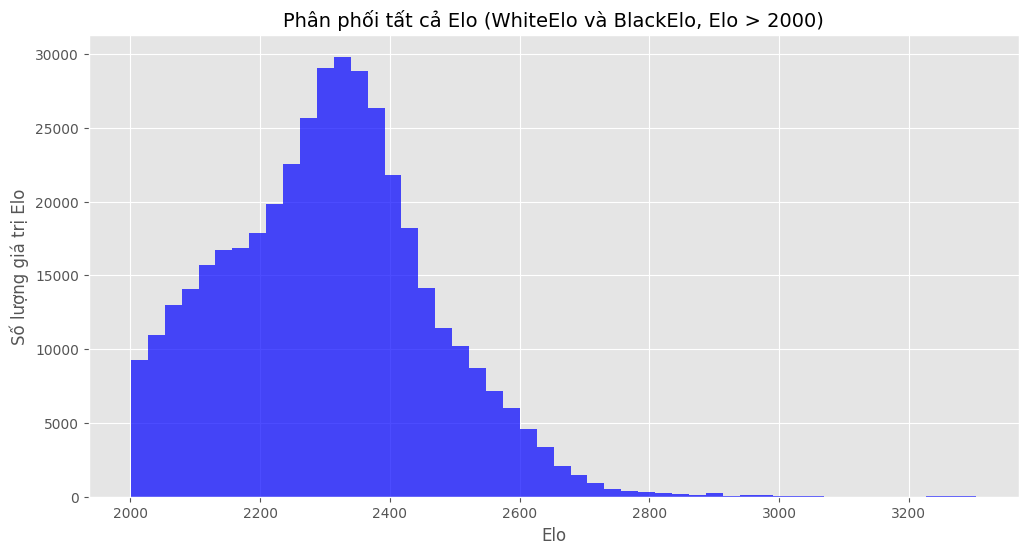

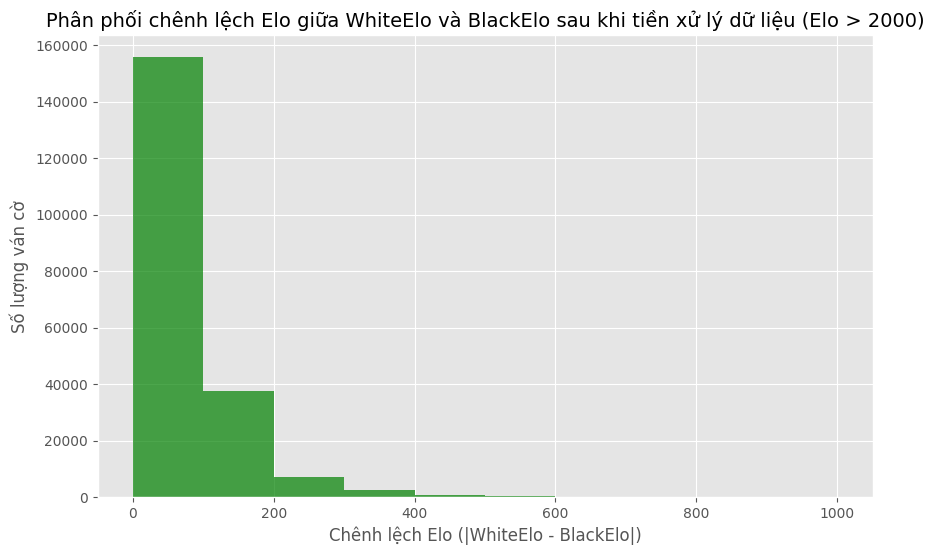

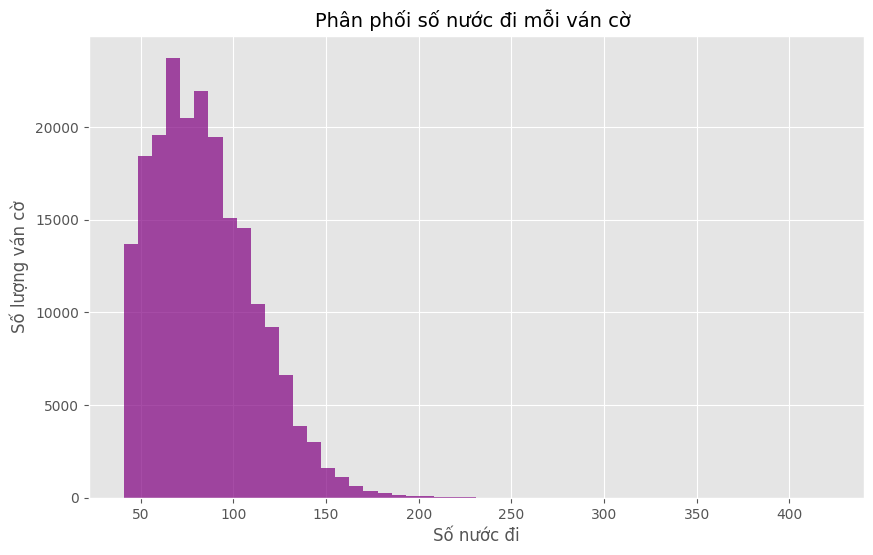


Thống kê cơ bản (sau khi lọc Elo > 2000):
Trung bình tất cả Elo: 2306.19
Trung bình chênh lệch Elo: 71.53
Trung bình số nước đi: 84.55
Độ lệch chuẩn tất cả Elo: 157.42
Độ lệch chuẩn chênh lệch Elo: 76.91
Độ lệch chuẩn số nước đi: 27.48


In [41]:
df_png = pd.read_csv('ai/data/pgn_chess_data.csv')
df_pgn_filtered = df_png.copy()
# Tính chênh lệch Elo tuyệt đối
df_pgn_filtered['EloDifference'] = abs(df_pgn_filtered['WhiteElo'] - df_pgn_filtered['BlackElo'])

# Kết hợp tất cả Elo (white_rating và black_rating)
all_elo = pd.concat([df_pgn_filtered['WhiteElo'], df_pgn_filtered['BlackElo']]).reset_index(drop=True)

# Kiểm tra dữ liệu sau xử lý
print("\nThông tin bảng dữ liệu sau xử lý và lọc:")
print(df_pgn_filtered.info())
print("\n5 hàng đầu tiên của bảng sau xử lý:")
print(df_pgn_filtered.head())

# Thiết lập kiểu hiển thị cho biểu đồ
plt.style.use('ggplot')

# 1. Histogram cho tất cả Elo (white_rating và black_rating kết hợp)
plt.figure(figsize=(12, 6))
plt.hist(all_elo, bins=50, color='blue', alpha=0.7)
plt.title('Phân phối tất cả Elo (WhiteElo và BlackElo, Elo > 2000)', fontsize=14)
plt.xlabel('Elo', fontsize=12)
plt.ylabel('Số lượng giá trị Elo', fontsize=12)
plt.grid(True)
plt.show()

# 2. Histogram cho chênh lệch Elo (bin width = 100)
max_diff = df_pgn_filtered['EloDifference'].max()
bins = range(0, int(max_diff) + 100, 100)  # Tạo bins với bước 100
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['EloDifference'], bins=bins, color='green', alpha=0.7)
plt.title('Phân phối chênh lệch Elo giữa WhiteElo và BlackElo sau khi tiền xử lý dữ liệu (Elo > 2000)', fontsize=14)
plt.xlabel('Chênh lệch Elo (|WhiteElo - BlackElo|)', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# 3. Histogram cho số nước đi (MoveCount)
plt.figure(figsize=(10, 6))
plt.hist(df_pgn_filtered['MoveCount'], bins=50, color='purple', alpha=0.7)
plt.title('Phân phối số nước đi mỗi ván cờ ', fontsize=14)
plt.xlabel('Số nước đi', fontsize=12)
plt.ylabel('Số lượng ván cờ', fontsize=12)
plt.grid(True)
plt.show()

# Thống kê cơ bản
print("\nThống kê cơ bản (sau khi lọc Elo > 2000):")
print("Trung bình tất cả Elo:", round(all_elo.mean(), 2))
print("Trung bình chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].mean(), 2))
print("Trung bình số nước đi:", round(df_pgn_filtered['MoveCount'].mean(), 2))
print("Độ lệch chuẩn tất cả Elo:", round(all_elo.std(), 2))
print("Độ lệch chuẩn chênh lệch Elo:", round(df_pgn_filtered['EloDifference'].std(), 2))
print("Độ lệch chuẩn số nước đi:", round(df_pgn_filtered['MoveCount'].std(), 2))

In [21]:
data = np.load("data/chess_data_0.npy", allow_pickle=True).item()
X = data["X"]
y = data["y"]

# Ví dụ:
print(len(X), len(y))
print(X[0].keys())  # 'board', 'history', 'white_elo', 'black_elo'
print(y[0])         # (from_square, to_square)


FileNotFoundError: [Errno 2] No such file or directory: 'data/chess_data_0.npy'